In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import numpy as np
import time
import csv
import h5py
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers.core import Dense,Activation,Dropout,TimeDistributedDense,RepeatVector
from keras.layers.recurrent import LSTM

np.random.seed(1234)

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)
DEPRECATION WARNING: softsign was moved from theano.sandbox.softsign to theano.tensor.nnet.nnet 


In [3]:
def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi


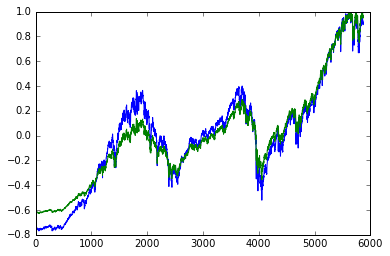

(5861L, 10L, 3L)
[[ -2.49277253e-02  -7.93159690e-02   7.53291316e+01]
 [ -4.27643463e-02  -8.84836673e-02   5.80924653e+01]
 [ -4.67280816e-02  -8.77138539e-02   5.50764536e+01]
 [ -4.11997930e-02  -8.77138539e-02   5.83261833e+01]
 [ -4.08867968e-02  -8.42847203e-02   5.85091863e+01]
 [ -3.75489600e-02  -8.56144118e-02   6.05011878e+01]
 [ -4.43289726e-02  -9.21227809e-02   5.47510260e+01]
 [ -4.44333012e-02  -8.98133498e-02   5.46649301e+01]
 [ -4.00523976e-02  -8.09255950e-02   5.76747130e+01]] [-0.02868281 -0.0807156 ]
[[ -0.73774066  -0.60239641  60.68894383]
 [ -0.73806714  -0.60267817  59.93308536]
 [ -0.73562219  -0.60107914  63.59023728]
 [ -0.73399289  -0.59806893  65.82861935]
 [ -0.73171065  -0.59882149  68.72869044]
 [ -0.72926566  -0.59477635  71.51753527]
 [ -0.72388757  -0.59496479  76.48521783]
 [ -0.7245395   -0.59421223  74.78254968]
 [ -0.72437676  -0.59496479  74.93256902]] [-0.72714719 -0.59590518]


C:\Users\Soham\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Soham\Anaconda2\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Soham\Anaconda2\lib\site-packages\ipykernel\__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [4]:
def load_data(path='aapl.csv',seq_len=10,ratio=1.0):
    with open(path) as f:
        data = csv.reader(f,delimiter=",")
        o = []
        c = []
        for line in data:
            try:
                o.append(float(line[3]))
                c.append(float(line[6]))
            except ValueError:
                pass
    f.close()
    o = np.array(list(reversed(o)))
    o -= o.mean() #normalize prices
    o /= o.max()
    c = np.array(list(reversed(c)))
    c -= c.mean()
    c /= c.max()
    
    axis = np.arange(len(o))
    plt.plot(axis,o)
    plt.plot(axis,c)
    plt.show()
    
    rsi = relative_strength(o,n=14)
    #print len(rsi),len(o)
    
    r1 = []
    r2 = []
    r3 = []
    for index in range(len(o) - seq_len):
        r1.append(o[index:index+seq_len])
        r2.append(c[index:index+seq_len])
        r3.append(rsi[index:index+seq_len])
        
    r1 = np.array(r1)
    r2 = np.array(r2)
    r3 = np.array(r3)
    result = np.stack((r1,r2,r3),axis=2)
        
    print result.shape
    
    np.random.shuffle(result)
    row = round(0.9 * result.shape[0])
    train = result[:row, :]
    X_train = train[:, :-1]
    y_train = train[:, -1,:2]
    X_test = result[row:, :-1]
    y_test = result[row:, -1,:2]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

    return [X_train, y_train, X_test, y_test]

X_train, y_train, X_test, y_test = load_data(path='spy.csv')
print X_train[23],y_train[23]
print X_test[3],y_test[3]

In [78]:
def build_model():
    model = Sequential()
    layers = [3,50,100,50,2]
    
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(
        input_dim=layers[1],
        output_dim=layers[2],
        return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(
        layers[3],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[4]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam",metrics=['accuracy'])
    print "Compilation Time : ", time.time() - start
    return model

In [86]:
def run_network(model=None, data=None, trained=0):
    global_start_time = time.time()
    epochs = 20
    ratio = 0.5
    sequence_length = 10
    path_to_dataset = 'goog.csv'

    if data is None:
        print 'Loading data... '
        X_train, y_train, X_test, y_test = load_data(
            path_to_dataset, sequence_length, ratio)
    else:
        X_train, y_train, X_test, y_test = data

    print 'Data Loaded'

    if model is None:
        print 'Building model...'
        model = build_model()
    if trained==0:
        print 'Training...'
        model.fit(
            X_train, y_train,
            batch_size=32, nb_epoch=epochs, validation_split=0.05)
        
    predicted = model.predict(X_test)
    predicted = np.reshape(predicted, (predicted.size,))
    
    print 'Total Duration (s) : ', time.time() - global_start_time
    
    return model, y_test, predicted

Loading data... 


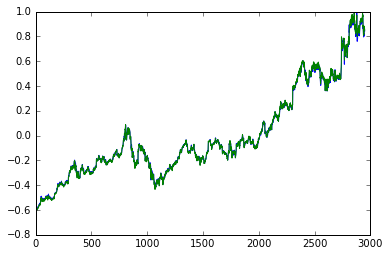

(2940L, 10L, 3L)
Data Loaded
Building model...


C:\Users\Soham\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Soham\Anaconda2\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Soham\Anaconda2\lib\site-packages\ipykernel\__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Compilation Time :  0.223000049591
Training...
Train on 2513 samples, validate on 133 samples
Epoch 1/20
2513/2513 [==============================] - 6s - loss: 0.0533 - acc: 0.5165 - val_loss: 0.0036 - val_acc: 0.5113
Epoch 2/20
2513/2513 [==============================] - 4s - loss: 0.0096 - acc: 0.4982 - val_loss: 0.0019 - val_acc: 0.5714
Epoch 3/20
2513/2513 [==============================] - 4s - loss: 0.0075 - acc: 0.4891 - val_loss: 0.0059 - val_acc: 0.6316
Epoch 4/20
2513/2513 [==============================] - 4s - loss: 0.0067 - acc: 0.5125 - val_loss: 0.0012 - val_acc: 0.6165
Epoch 5/20
2513/2513 [==============================] - 4s - loss: 0.0064 - acc: 0.5245 - val_loss: 0.0013 - val_acc: 0.6917
Epoch 6/20
2513/2513 [==============================] - 4s - loss: 0.0054 - acc: 0.5149 - val_loss: 0.0012 - val_acc: 0.5714
Epoch 7/20
2513/2513 [==============================] - 4s - loss: 0.0051 - acc: 0.5058 - val_loss: 0.0011 - val_acc: 0.6391
Epoch 8/20
2513/2513 [=========

'try:\n    m = model_from_json(open(\'lstm_arch.json\').read())\n    m.load_weights(\'lstm_weights.h5\')\n    m.compile(loss="mse", optimizer="adam",metrics=[\'accuracy\'])\n    print \'Model Loaded From File\'\n    run_network(model=m,trained=1)\nexcept (RuntimeError, TypeError, NameError) as err:\n    print err\n    print \'Running Network\'\n    m, true, pred = run_network()'

In [87]:
m, true, pred = run_network()
'''try:
    m = model_from_json(open('lstm_arch.json').read())
    m.load_weights('lstm_weights.h5')
    m.compile(loss="mse", optimizer="adam",metrics=['accuracy'])
    print 'Model Loaded From File'
    run_network(model=m,trained=1)
except (RuntimeError, TypeError, NameError) as err:
    print err
    print 'Running Network'
    m, true, pred = run_network()'''

In [9]:
open('lstm_arch.json','w').write(m.to_json())
m.save_weights('lstm_weights.h5')

In [88]:
#for i in range(len(pred)):
#    if(np.absolute(true[i]-pred[i]) > 10):
#        print true[i],pred[i]
print np.absolute(sum(pred[::2]-true[:,0]))/len(true)
print np.absolute(sum(pred[1::2]-true[:,1]))/len(true)

0.0135073262348
0.0149074189603


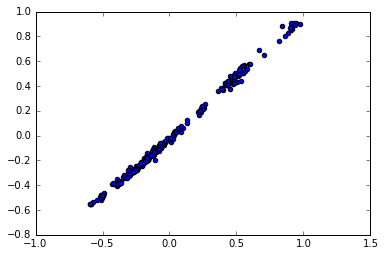

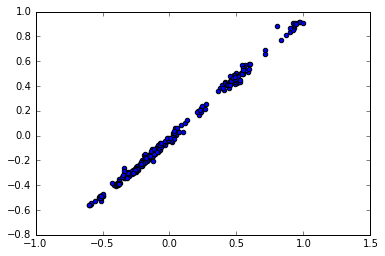

In [89]:
l = true.shape[0]
axis = np.arange(l)
a,b = np.split(pred,2)
plt.scatter(true[:,0],pred[::2])
plt.show()
plt.scatter(true[:,1],pred[1::2])
plt.show()

In [21]:
print true.shape
print pred[l:].shape
print pred[:l].shape

(387L, 2L)
(387L,)
(387L,)


In [96]:
def test_data(path='goog.csv',seq_len=10,model=m,cool=None):
    with open(path) as f:
        data = csv.reader(f,delimiter=",")
        o = []
        c = []
        for line in data:
            try:
                o.append(float(line[3]))
                c.append(float(line[6]))
            except ValueError:
                pass
    f.close()

    o = np.array(list(reversed(o)))
    c = np.array(list(reversed(c)))
    
    rsi = relative_strength(o,n=14)
    
    a = (o.mean()+c.mean())/2
    m = (o.max()+c.max())/2
    
    o -= o.mean() #normalize prices
    o /= o.max()
    c -= c.mean()
    c /= c.max()
    
    
    r1 = []
    r2 = []
    r3 = []
    for index in range(len(o) - seq_len):
        r1.append(o[index:index+seq_len])
        r2.append(c[index:index+seq_len])
        r3.append(rsi[index:index+seq_len])
        
    r1 = np.array(r1)
    r2 = np.array(r2)
    r3 = np.array(r3)
    result = np.stack((r1,r2,r3),axis=2)

    X = result[:,:-1]
    Y = result[:,-1,:2]
    
    X = np.reshape(X,(X.shape[0],X.shape[1],3))
    
    if cool is None:
        mehz  = model.predict(X)
    else:
        mehz = cool
    
    bought = False
    cur_prof = 0
    days_held = 0
    cum_prof = 0
    prices = []
    
    X = np.array(X)*m+a
    Y = np.array(Y)*m+a
    meh = np.array(mehz)*m+a
    
    for i in range(len(X)):
        if bought==False and meh[i,0] > X[i,-1,0]:
            bought = True
            cur_prof += Y[i,0]-X[i,-1,0]
            days_held += 1
            prices.append(X[i,-1,0])
            prices.append(Y[i,0])
        elif bought==True and meh[i,0] > X[i,-1,0]:
            cur_prof += Y[i,0]-X[i,-1,0]
            prices.append(Y[i,0])
            days_held += 1
        elif bought==True and meh[i,0] < X[i,-1,0]:
            bought = False
            cum_prof += cur_prof
            print days_held, cur_prof
            #print prices
            del prices[:]
            cur_prof = 0
            days_held = 0
        
    print cum_prof
    return mehz

cool = test_data()

39 71.2415180486
2 14.0585972374
119 24.8989613722
21 33.147800956
1 6.9784844118
1 12.4664187551
6 -4.84428772275
2 -1.8970637236
1 5.80975765351
2 -4.20064110225
2 3.31986151629
14 16.0064751678
4 -2.20194896489
1 6.38565199817
1 -2.71009103371
1 14.194101789
1 4.18370303329
1 3.28598537837
1 24.2553147517
12 -17.1582638572
3 9.16349530772
1 1.84624951671
1 -0.863841516994
4 -2.6254006889
3 3.11660468876
3 21.9178612351
1 -3.47230413694
3 0.321823310253
1 -0.829965379073
1 3.92963199888
1 -0.101628413764
2 -0.101628413764
3 -6.35177586025
1 0.846903448033
2 2.57458648202
1 2.04950634424
1 4.01432234368
1 6.01301448104
3 -17.4123348916
1 -3.92963199888
1 3.4892422059
3 -3.21823310253
1 18.9198230291
1 36.5692908861
3 -23.1374022003
2 -4.03126041264
1 10.6371073073
3 -12.3309142034
6 -9.40062827317
1 8.74004358371
2 2.71009103371
1 -4.23451724017
1 5.65731503286
4 -1.40585972374
1 3.23517117149
1 -1.06709834452
1 3.82800358511
1 16.5993075815
2 16.0234132368
1 13.9230926857
2 24.390819